## Importation des packages

In [213]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from optbinning import OptimalBinning



from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from catboost import CatBoostClassifier, Pool, metrics
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

import optuna
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score


from optbinning import BinningProcess

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from category_encoders import CatBoostEncoder

### Données

In [214]:
df = pd.read_pickle("df_modele.pkl") #Données après feature eng

### Récapitulatif de l'analayse de données

Après l'analyse de données ainsi que lors des développements de nos premiers modèles nous avons remarqué que certaines variables étaient beaucoup trop importantes et écrasaient les autres variables du modèle. En effet, notamment la variable *TerminMonths* avait un pouvoir beaucoup trop important. Dans un premier temps nous avons essayé de la discrétiser pour réduire son effet mais les résultats obtenus n'étaient pas satisfaisants. Ainsi nous avons décidé d'opter pour une méthode de segmentation en se penchant d'avantage sur l'analyse de cette variable.

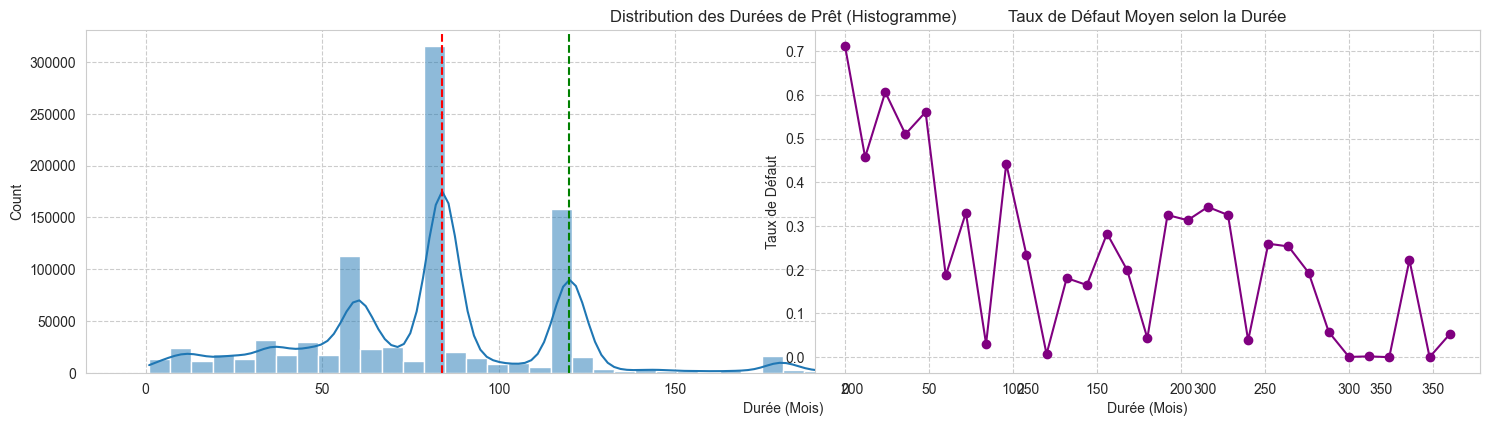

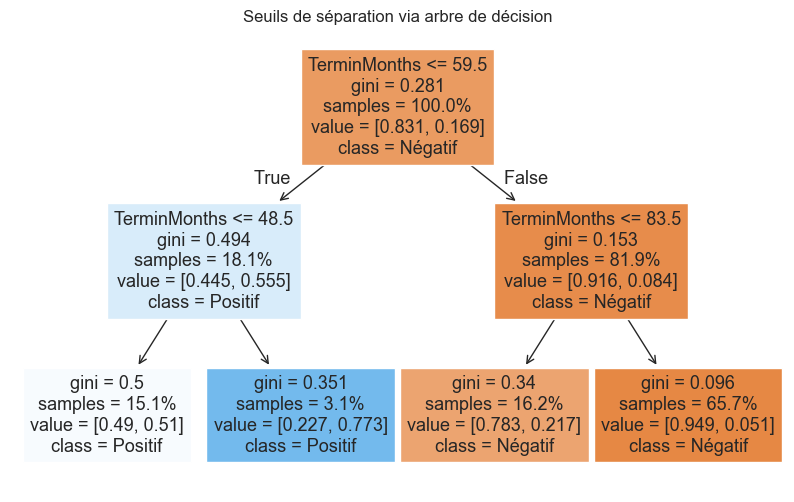

In [220]:
df_analyze = df.copy()
df_analyze['Target'] = df["LoanStatus"]
plt.figure(figsize=(15, 5))

plt.subplot(1, 1, 1)

sns.histplot(data=df_analyze[df_analyze['TerminMonths'] <= 360], x='TerminMonths', bins=60, kde=True)
plt.title("Distribution des Durées de Prêt (Histogramme)")
plt.xlabel("Durée (Mois)")
plt.axvline(x=84, color='r', linestyle='--', label='7 ans (84 mois)')
plt.axvline(x=120, color='g', linestyle='--', label='10 ans (120 mois)')
plt.axvline(x=240, color='b', linestyle='--', label='20 ans (240 mois)')
plt.legend()
plt.subplot(1, 2, 2)

df_analyze['Term_Year_Bin'] = (df_analyze['TerminMonths'] // 12) * 12
default_rate = df_analyze.groupby('Term_Year_Bin')['Target'].mean()
default_rate = default_rate[default_rate.index <= 360]

plt.plot(default_rate.index, default_rate.values, marker='o', color='purple')
plt.title("Taux de Défaut Moyen selon la Durée")
plt.xlabel("Durée (Mois)")
plt.ylabel("Taux de Défaut")
plt.grid(True)

plt.tight_layout()
plt.show()


#Arbre de décision
tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=500)
tree.fit(df_analyze[['TerminMonths']], df_analyze['Target'])

plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=['TerminMonths'], filled=True, class_names=['Négatif', 'Positif'], proportion=True)
plt.title("Seuils de séparation via arbre de décision")
plt.show()

Ainsi basé sur les résultats de l'arbre de décision ainsi que des graphiques précédent nous avons décidé de changer notre problème et de nous concentrer sur les prêts avec une durée inférieure à 60 mois (5ans). 
Les analyses avaient également montré un fort pouvoir discriminant de la variable *CollateralInd*. Là encore nous avons opté pour une segmentation en plus de de la durée du prêt nous nous concentrons ici sur les prêts à court terme qui possèdent un collatéral. 


In [262]:
# Elimination des colonnes inutiles et redondantes

data = df.drop(columns={"ProcessingMethod", # On a deja subprogram
                        "FirstDisbursementDate", # On a calculé le décalage p/r à la date de paiement
                        "NAICSCode", # redondant
                        "ProjectCounty", # redondant
                        "Industry", # redondant
                        "Year_Quarter", 
                        "year", # a servi dans le feature eng
                        'JobsSupported_cut', 
                        "year_lag", #a servi dans le feature eng
                        'BankState',
                        "TerminMonths_cut",
                        "BankName", # Inutile au sens métier 
                        "GrossApproval", # on a pris le log
                        "SBAGuaranteedApproval", # on a pris le log
                        'ApprovalFY', # inutile
                        "SBADistrictOffice", # On a deja projectstate
                        "BorrState",
                        "ProjectState",
                       })

In [263]:
# On applique la segmentation évoqué plus haut
data = data[(data["TerminMonths"] < 60) & (data["CollateralInd"] ==1)]
data = data.drop("CollateralInd", axis=1)

Concernant la période d'étude, nous avons décidé de ne garder que les données disponibles après 2015. D'abord pour éliminer la crise de 2008 qui était une situation d'exception et qui ne reflète plus l'économie actuelle. Idéalement nous aurions voulu réduire d'avantage la période d'étude afin d'avoir les données les plus actuelles possibles sur lesquelles apprendre, cependant en raison des contraintes du nombre d'observations nous avons décidé d'étendre la période en commencant en 2015. De même nous avons décidé de nous arrêter fin 2024 dans l'idée que les prêts accordés en 2025 n'ont pas encore eu le temps d'entrer en défaut et que le taux de défaut sur cette période est artificiellement bas. 

In [264]:
data = data[(data["ApprovalDate"] > "2015-01-01") & (data["ApprovalDate"] < "2024-12-12")]

In [265]:
print("-"*100)
print(f"Nombre d'observations dans l'échantillon: {data.shape[0]}")
print("-"*100)
print(f"Nombre d'observations négatives(0) sur l'échantillon: {data.LoanStatus.value_counts()[0]} / {data.LoanStatus.value_counts(normalize=1)[0]}")
print("-"*100)
print(f"Nombre d'observations positives (1) sur l'échantillon: {data.LoanStatus.value_counts()[1]} / {data.LoanStatus.value_counts(normalize=1)[1]}")
print("-"*100)

----------------------------------------------------------------------------------------------------
Nombre d'observations dans l'échantillon: 16838
----------------------------------------------------------------------------------------------------
Nombre d'observations négatives(0) sur l'échantillon: 11650 / 0.6918873975531535
----------------------------------------------------------------------------------------------------
Nombre d'observations positives (1) sur l'échantillon: 5188 / 0.3081126024468464
----------------------------------------------------------------------------------------------------


## Découpage Train/test

Pour le découpage train test, contraints de respecter la temporalité des données, nous avons décidé d'opter pour un découpage à la main en faisant 70/30 de sorte à avoir suffisamment d'observations positives dans chaque échantillons.

In [266]:
data = data.sort_values(by='ApprovalDate').reset_index(drop=True)

split_index = int(len(data) * 0.75) #70% pour le test

train = data.iloc[:split_index].copy()
test  = data.iloc[split_index:].copy()

target = 'LoanStatus' 

# Train
X_train = train.drop(target, axis=1)
y_train = train[target]

# Test
X_test = test.drop(target, axis=1)
y_test = test[target]


print("-"*100)
print(f"Période Train : {train['ApprovalDate'].min().date()} à {train['ApprovalDate'].max().date()} | Lignes: {len(train)}")
print("-"*100)
print(f"Période Test  : {test['ApprovalDate'].min().date()} à {test['ApprovalDate'].max().date()} | Lignes: {len(test)}")
print("-"*100)
print(f"Volume Total  : {len(data)}")
print("-"*100)
print(f"Ratio Train   : {len(train) / len(data):.2%}")
print("-"*100)
print(f"Ratio Test    : {len(test) / len(data):.2%}")
print("-"*100)
print(f'Repartition des classes dans Train: {train.LoanStatus.value_counts(normalize=1)}')
print("-"*100)
print(f'Repartition des classes dans Test: {test.LoanStatus.value_counts(normalize=1)}')

----------------------------------------------------------------------------------------------------
Période Train : 2015-01-02 à 2019-05-06 | Lignes: 12628
----------------------------------------------------------------------------------------------------
Période Test  : 2019-05-06 à 2024-12-06 | Lignes: 4210
----------------------------------------------------------------------------------------------------
Volume Total  : 16838
----------------------------------------------------------------------------------------------------
Ratio Train   : 75.00%
----------------------------------------------------------------------------------------------------
Ratio Test    : 25.00%
----------------------------------------------------------------------------------------------------
Repartition des classes dans Train: LoanStatus
0    0.643728
1    0.356272
Name: proportion, dtype: float64
----------------------------------------------------------------------------------------------------
Repart

**Malgré plusieurs essais et contraints par la temporalité des données, nous n'avons pas résussi à avoir des classes équilibrés (ce qui peut poser problème dans nos résultats plus tard)**

In [267]:
X_train = X_train.set_index("ApprovalDate")
X_test = X_test.set_index("ApprovalDate")

## Encodage des variables catégorielles

##### CatBoost encoder : 
Nous avons décidé d'opter pour un catboost encoder au lieu d'un one hot encoding menant à des dimensions trop élevées notamment avec des variables avec un grand nombre de modalités.

In [268]:
encoder = CatBoostEncoder(cols=['Subprogram',
    'BusinessType','IndustryName'])

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

## Modèle 1 : Régression Logistique avec Lasso (+ filtrage des variables trop corrélées)

In [286]:
tscv = TimeSeriesSplit(n_splits=3)
seuil_correlation = 0.6
    
# ##############################################################################
# 1. SÉLECTION DE VARIABLES VIA LASSO (Logistic Regression L1)
#    (Scaling Manuelle sur X_train_filtered)
# ##############################################################################

print("*" * 100)
print(f"--- 1. FILTRAGE DES CORRÉLATIONS (Spearman > {seuil_correlation}) ---")
print("----- ON garde les variables les plus corrélées à y ----")
print("*" * 100)

feature_names = X_train_encoded.columns.tolist()
corr_matrix_X = X_train_encoded.corr(method="spearman").abs()
corr_X_Y = X_train_encoded.apply(lambda x: x.corr(y_train)).abs().sort_values(ascending=False) # Corrélation avec la target

vars_to_check = corr_X_Y.index.tolist()
vars_to_drop = set()
vars_uncorrelated = []

for i in range(len(vars_to_check)):
    col_1 = vars_to_check[i]
    if col_1 in vars_to_drop:
        continue
    vars_uncorrelated.append(col_1)
    for j in range(i + 1, len(vars_to_check)):
        col_2 = vars_to_check[j]
        if col_2 in vars_to_drop:
            continue
        if corr_matrix_X.loc[col_1, col_2] > seuil_correlation:
            vars_to_drop.add(col_2)



print(f"\nSeuil de Corrélation utilisé : > {seuil_correlation}")
print(f"Variables de départ : {len(feature_names):,}")
print(f"Variables ayant passé le filtre : {len(vars_uncorrelated):,}")

# Variables retenus 
X_train_filtered = X_train_encoded[vars_uncorrelated].copy()
X_test_filtered = X_test_encoded[vars_uncorrelated].copy()


# ##############################################################################
# 2. SÉLECTION DE VARIABLES LASSO
# ##############################################################################

# Mise à l'échelle des données pour la GridSearch Lasso
scaler_lasso = StandardScaler() # On standardise pour le lasso
X_train_scaled_lasso = scaler_lasso.fit_transform(X_train_filtered)
X_train_scaled_lasso = pd.DataFrame(X_train_scaled_lasso, columns=X_train_filtered.columns, index=X_train_filtered.index)


lasso_model = LogisticRegression(penalty='l1', solver='saga',
    max_iter=5000,
    random_state=42,
    class_weight='balanced'
)

param_grid_lasso = {
    'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
}

# Choix des hyparparam du lasso 
grid_search_lasso = GridSearchCV(
    lasso_model,
    param_grid_lasso,
    cv=tscv, # On utilise le time series cv pour éviter le data leakage temporelle
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search_lasso.fit(X_train_scaled_lasso, y_train)

best_lasso = grid_search_lasso.best_estimator_
best_C = best_lasso.C

print(f"\nMeilleur paramètre Lasso : C = {best_C}")

# ################################################
#  On prend les variables selectionnées par lasso
###################################################
coeffs = best_lasso.coef_[0]
feature_names_filtered = X_train_filtered.columns

lasso_coefs = pd.DataFrame({
    'Variable': feature_names_filtered,
    'Coefficient': coeffs,
    'Importance_Absolue': np.abs(coeffs)
})

vars_final = lasso_coefs[lasso_coefs['Coefficient'] != 0]['Variable'].tolist()


print(f"\nVariables sélectionnées par Lasso : {len(vars_final)} / {len(feature_names_filtered):,}")
X_train_final = X_train_filtered[vars_final].copy()
X_test_final = X_test_filtered[vars_final].copy()



# ##############################################################################
# 3.                          Regression Logistique
# ##############################################################################

# Modèle de base
logreg_base = LogisticRegression(
    penalty='l2', 
    solver='lbfgs',
    max_iter=5000,
    random_state=42,
    class_weight='balanced'
)

param_grid_logreg = {
    'C': [0.01, 0.1, 1.0, 10.0]
}

auc_scores_logreg = []
best_params_logreg_per_fold = []


for fold, (train_index, test_index) in enumerate(tscv.split(X_train_final), 1):
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # 1. FIT LE SCALER SUR LE TRAIN FOLD SEULEMENT
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    # 2. TRANSFORMER LE VAL FOLD
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    # 3. Effectuer une petite GridSearch sur le C du fold
    inner_grid_search = GridSearchCV(
        logreg_base,
        param_grid_logreg,
        scoring='roc_auc',
        cv=[(range(len(X_train_scaled)), range(len(X_val_scaled)))], # Utilisation des indices internes
        verbose=0,
        n_jobs=-1
    )
    
    inner_grid_search.fit(
        np.concatenate([X_train_scaled, X_val_scaled]), # Concaténation pour simuler un split (X_val sera utilisé comme test)
        np.concatenate([y_train_fold, y_val_fold])
    )
    
    best_logreg_fold = inner_grid_search.best_estimator_
    best_params_logreg_per_fold.append(inner_grid_search.best_params_['C'])
    
    # Préd sur l'ensemble de Validation du Fold 
    probs_val_fold = best_logreg_fold.predict_proba(X_val_scaled)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, probs_val_fold)
    auc_scores_logreg.append(auc_fold)
    
    print(f"  Fold {fold}: AUC = {auc_fold:.4f} (Meilleur C: {inner_grid_search.best_params_['C']})")

auc_cv_mean = np.mean(auc_scores_logreg)
optimal_C = np.mean(best_params_logreg_per_fold) # Moyenne des meilleurs C ou le C le plus fréquent en fct des splits

print(f"\nAUC Moyenne Validation (CV) : {auc_cv_mean:.4f}")
print(f"C Moyen/Optimal pour le modèle final : {optimal_C:.4f}")


# ##############################################################################
# 4.                          Entrainement final
# ##############################################################################

final_scaler = StandardScaler()
X_train_final_scaled = final_scaler.fit_transform(X_train_final)
X_test_final_scaled = final_scaler.transform(X_test_final)

logreg_final_model = LogisticRegression(
    penalty='l2',
    C=optimal_C, 
    solver='lbfgs',
    max_iter=5000,
    random_state=42,
    class_weight='balanced'
)

logreg_final_model.fit(X_train_final_scaled, y_train)


# AUC sur le Train Total
probs_train_total = logreg_final_model.predict_proba(X_train_final_scaled)[:, 1]
auc_train_total = roc_auc_score(y_train, probs_train_total)

# AUC sur le Test
probs_test = logreg_final_model.predict_proba(X_test_final_scaled)[:, 1]
auc_test = roc_auc_score(y_test, probs_test)

****************************************************************************************************
--- 1. FILTRAGE DES CORRÉLATIONS (Spearman > 0.6) ---
----- ON garde les variables les plus corrélées à y ----
****************************************************************************************************

Seuil de Corrélation utilisé : > 0.6
Variables de départ : 45
Variables ayant passé le filtre : 24

Meilleur paramètre Lasso : C = 0.01

Variables sélectionnées par Lasso : 13 / 24
  Fold 1: AUC = 0.7183 (Meilleur C: 0.1)
  Fold 2: AUC = 0.7446 (Meilleur C: 0.1)
  Fold 3: AUC = 0.7834 (Meilleur C: 0.1)

AUC Moyenne Validation (CV) : 0.7488
C Moyen/Optimal pour le modèle final : 0.1000


## Résultats du premier modèle (Lasso + Logistique)

In [287]:
# ==============================================================================
# 5. RÉSULTATS ET IMPORTANCE
# ==============================================================================

print("--- RÉSUMÉ DES PERFORMANCES AUC ---")
print("-" * 100)
print(f"AUC sur le Train Total : {auc_train_total:.4f}")
print(f"AUC Moyenne Validation (CV) : {auc_cv_mean:.4f}")
print(f"AUC sur le Test (Ensemble final) : {auc_test:.4f}")
print("-" * 100)

print("---Analayse d'overfit / underfit ---")
print(f"\nDelta (Train - Test) : {auc_train_total - auc_test:+.4f}")


print("--- Importance des variables ---")
print("-" * 100)

importance_df = pd.DataFrame({
    'Variable': X_train_final.columns,
    'Coefficient': logreg_final_model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("\n")
print(importance_df.to_string(index=False))

--- RÉSUMÉ DES PERFORMANCES AUC ---
----------------------------------------------------------------------------------------------------
AUC sur le Train Total : 0.7420
AUC Moyenne Validation (CV) : 0.7488
AUC sur le Test (Ensemble final) : 0.6983
----------------------------------------------------------------------------------------------------
---Analayse d'overfit / underfit ---

Delta (Train - Test) : +0.0436
--- Importance des variables ---
----------------------------------------------------------------------------------------------------


                              Variable  Coefficient
                            Subprogram     1.104895
                     emprunt_state_tot     0.312603
                          IndustryName     0.261645
                        RevolverStatus     0.148072
                  emprunt_industry_tot     0.064198
                    emprunt_state_mean     0.050524
    Inflation_variation_Lag1_Trimestre    -0.047320
                Chomage_variat

## Lasso + XGBOOST

In [301]:
tscv = TimeSeriesSplit(n_splits=3)
seuil_correlation = 0.6


# ##############################################################################
# 1. SÉLECTION DE VARIABLES VIA LASSO (Logistic Regression L1)
#    (Scaling Manuelle sur X_train_filtered)
# ##############################################################################
print("*" * 100)
print(f"--- 1. FILTRAGE DES CORRÉLATIONS (Spearman > {seuil_correlation}) ---")
print("----- ON garde les variables les plus corrélées à y ----")
print("*" * 100)

feature_names = X_train_encoded.columns.tolist()
corr_matrix_X = X_train_encoded.corr(method="spearman").abs()

corr_X_Y = X_train_encoded.apply(
    lambda x: x.corr(y_train, method="spearman")
).abs().sort_values(ascending=False)

vars_to_check = corr_X_Y.index.tolist()
vars_to_drop = set()
vars_uncorrelated = []

for i in range(len(vars_to_check)):
    col_1 = vars_to_check[i]
    if col_1 in vars_to_drop:
        continue
    vars_uncorrelated.append(col_1)
    for j in range(i + 1, len(vars_to_check)):
        col_2 = vars_to_check[j]
        if col_2 in vars_to_drop:
            continue
        if corr_matrix_X.loc[col_1, col_2] > seuil_correlation:
            vars_to_drop.add(col_2)


print(f"\nVariables de départ : {len(feature_names):,}")
print(f"Variables supprimées (corrélation > 0.6) : {len(vars_to_drop)}")
print(f"Variables non corrélées retenues : {len(vars_uncorrelated):,}")

X_train_filtered = X_train_encoded[vars_uncorrelated].copy()
X_test_filtered = X_test_encoded[vars_uncorrelated].copy()

# ##############################################################################
# 2. SÉLECTION DE VARIABLES LASSO
# ##############################################################################

lasso_model = LogisticRegression(
    penalty='l1',
    solver='saga',
    max_iter=10000,
    random_state=42,
    class_weight='balanced'
)

param_grid_lasso = {
    'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
}

grid_search_lasso = GridSearchCV(
    lasso_model,
    param_grid_lasso,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search_lasso.fit(X_train_filtered, y_train)

best_lasso = grid_search_lasso.best_estimator_
print(f"\nMeilleurs paramètres Lasso : C = {best_lasso.C}")

coeffs = best_lasso.coef_[0]
feature_names_filtered = X_train_filtered.columns

lasso_coefs = pd.DataFrame({
    'Variable': feature_names_filtered,
    'Coefficient': coeffs,
    'Importance_Absolue': np.abs(coeffs)
})

vars_final = lasso_coefs[lasso_coefs['Coefficient'] != 0]['Variable'].tolist()

print(f"\nVariables sélectionnées par Lasso : {len(vars_final)} / {len(feature_names_filtered):,}")

X_train_lasso = X_train_filtered[vars_final].copy()
X_test_lasso = X_test_filtered[vars_final].copy()

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
new_columns = [regex.sub("_", col) for col in vars_final]
X_train_lasso.columns = new_columns
X_test_lasso.columns = new_columns

count_neg = np.sum(y_train == 0)
count_pos = np.sum(y_train == 1)
scale_pos_weight = np.sqrt(count_neg / count_pos)


xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight, # Pour équlibre les classes
    random_state=42,
    n_jobs=-1,
    subsample=0.7,
    colsample_bytree=0.7
)

param_grid_xgb_enrichie = {
    
    'n_estimators': [300, 750],         
    'learning_rate': [0.005, 0.01, 0.05],     
    'max_depth': [3, 4, 6],                 
    #'reg_alpha': [1, 4, 8],                   
    'reg_lambda': [1, 3, 5],                  
    'subsample': [0.6, 0.8, 1.0],             
    'colsample_bytree': [0.6, 0.8, 1.0],      
    #'min_child_weight': [1, 10, 50]           
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_lasso, y_train)

best_xgb_params = grid_search_xgb.best_params_
auc_cv_mean = grid_search_xgb.best_score_
best_estimator = grid_search_xgb.best_estimator_

print("\nMeilleurs hyperparamètres XGBoost (GridSearch) :")
for k, v in best_xgb_params.items():
    print(f" - {k}: {v}")
print(f"\nAUC Moyenne Validation (CV) : {auc_cv_mean:.4f}")

# ##############################################################################
# 4.                          Entrainement final
# ##############################################################################
xgb_final_model = best_estimator

probs_train_total = xgb_final_model.predict_proba(X_train_lasso)[:, 1]
auc_train_total = roc_auc_score(y_train, probs_train_total)

probs_test = xgb_final_model.predict_proba(X_test_lasso)[:, 1]
auc_test = roc_auc_score(y_test, probs_test)


****************************************************************************************************
--- 1. FILTRAGE DES CORRÉLATIONS (Spearman > 0.6) ---
----- ON garde les variables les plus corrélées à y ----
****************************************************************************************************

Variables de départ : 45
Variables supprimées (corrélation > 0.6) : 20
Variables non corrélées retenues : 25

Meilleurs paramètres Lasso : C = 0.001

Variables sélectionnées par Lasso : 10 / 25
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Meilleurs hyperparamètres XGBoost (GridSearch) :
 - learning_rate: 0.05
 - max_depth: 3
 - n_estimators: 500
 - reg_alpha: 1

AUC Moyenne Validation (CV) : 0.8776


## Résultats du deuxième modèle (LASSO + XGB)

In [306]:
print("--- RÉSUMÉ DES PERFORMANCES AUC ---")
print("-" * 100)
print(f"AUC sur le Train Total : {auc_train_total:.4f}")
print(f"AUC Moyenne Validation (CV) : {auc_cv_mean:.4f}")
print(f"AUC sur le Test (Ensemble final) : {auc_test:.4f}")
print("-" * 100)

print("---Analayse d'overfit / underfit ---")
print(f"Delta (Train - Test) : {auc_train_total - auc_test:+.4f}")

print("--- Importance des variables ---")

importance_df = pd.DataFrame({
    'Variable': new_columns,
    'Importance': xgb_final_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df.to_string(index=False))

--- RÉSUMÉ DES PERFORMANCES AUC ---
----------------------------------------------------------------------------------------------------
AUC sur le Train Total : 0.9100
AUC Moyenne Validation (CV) : 0.8776
AUC sur le Test (Ensemble final) : 0.8632
----------------------------------------------------------------------------------------------------
---Analayse d'overfit / underfit ---
Delta (Train - Test) : +0.0469
--- Importance des variables ---
                              Variable  Importance
                          TerminMonths    0.395017
                     emprunt_state_tot    0.121880
diff_premier_paiement_vs_approval_date    0.078542
        delta_emprunt_vs_industry_mean    0.077136
                  emprunt_industry_tot    0.074596
                    emprunt_state_mean    0.071604
                 emprunt_industry_mean    0.061428
                         JobsSupported    0.052486
                       emprunts_us_tot    0.037599
                       emprunts_us_med  

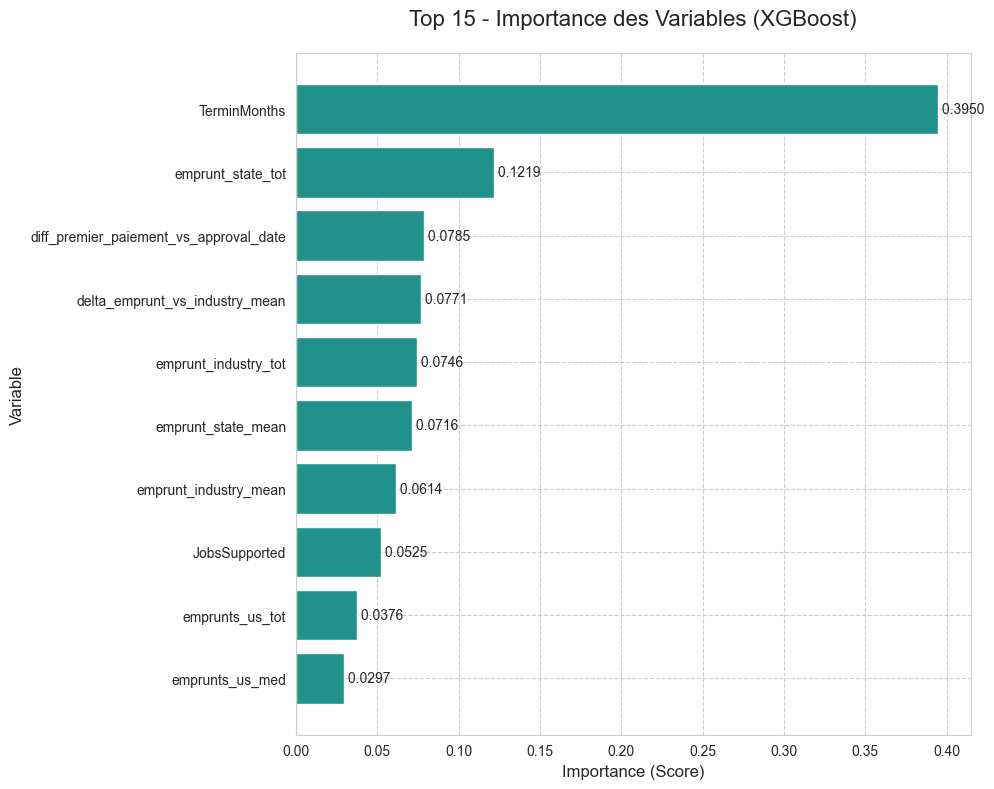

In [308]:
importance_df = importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.barh(
    importance_df_top15['Variable'], 
    importance_df_top15['Importance'], 
    color=sns.color_palette("viridis", 1)[0] 
)

plt.title('Top 15 - Importance des Variables (XGBoost)', fontsize=16, pad=20)
plt.xlabel('Importance (Score)', fontsize=12)
plt.ylabel('Variable', fontsize=12)

for index, value in enumerate(importance_df_top15['Importance']):
    plt.text(value, index, f' {value:.4f}', va='center')

plt.tight_layout()

## 3ème modèle : CatBoost sans encodage préalable

In [317]:
categorical_features_list = ['Subprogram', 'BusinessType', 'IndustryName'] 
tscv = TimeSeriesSplit(n_splits=3)
seuil_correlation = 0.6
    
print("*" * 100)
print(f"--- 1. FILTRAGE DES CORRÉLATIONS (Spearman > {seuil_correlation}) ---")
print("----- Uniquement sur les var numériques ----")
print("*" * 100)

X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)

feature_names_numeric = X_train_numeric.columns.tolist()
corr_matrix_X = X_train_numeric.corr(method="spearman").abs()
# Corrélation avec la target
corr_X_Y = X_train_numeric.apply(lambda x: x.corr(y_train, method="spearman")).abs().sort_values(ascending=False) 

vars_to_check = corr_X_Y.index.tolist()
vars_to_drop = set()
vars_uncorrelated_numeric = []

for i in range(len(vars_to_check)):
    col_1 = vars_to_check[i]
    if col_1 in vars_to_drop:
        continue
    vars_uncorrelated_numeric.append(col_1)
    for j in range(i + 1, len(vars_to_check)):
        col_2 = vars_to_check[j]
        if col_2 in vars_to_drop:
            continue
        if corr_matrix_X.loc[col_1, col_2] > seuil_correlation:
            vars_to_drop.add(col_2)


vars_final = vars_uncorrelated_numeric + [col for col in categorical_features_list if col in X_train.columns]


print(f"\nVariables Numériques de départ : {len(feature_names_numeric):,}")
print(f"Variables Numériques non corrélées retenues : {len(vars_uncorrelated_numeric):,}")
print(f"Variables Catégorielles incluses : {len(vars_final) - len(vars_uncorrelated_numeric):,}")


X_train_final = X_train[vars_final].copy()
X_test_final = X_test[vars_final].copy()

# ##############################################################################
# 2. Catbost 
# ##############################################################################

# Modèle de base CatBoost
cat_base = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0,
    auto_class_weights='Balanced', 
    bootstrap_type='Bernoulli',
    cat_features=categorical_features_list 
)


param_grid_cat = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'depth': [3, 5],
    'l2_leaf_reg': [1, 3] 
}

grid_search_cat = GridSearchCV(
    estimator=cat_base,
    param_grid=param_grid_cat,
    scoring='roc_auc',
    cv=tscv, 
    verbose=1,
    n_jobs=-1
)

grid_search_cat.fit(X_train_final, y_train)

best_cat_params = grid_search_cat.best_params_
auc_cv_mean = grid_search_cat.best_score_
cat_final_model = grid_search_cat.best_estimator_ # Le modèle entraîné final

print("\nMeilleurs hyperparamètres CatBoost (GridSearch) :")
for k, v in best_cat_params.items():
    print(f" - {k}: {v}")

print(f"\nAUC Moyenne Validation (CV) : {auc_cv_mean:.4f}")

# ##############################################################################
# 3. ÉVALUATION ET RÉSULTATS FINAUX (CatBoost)
# ##############################################################################

# AUC sur le Train Total
probs_train_total = cat_final_model.predict_proba(X_train_final)[:, 1]
auc_train_total = roc_auc_score(y_train, probs_train_total)

# AUC sur le Test
probs_test = cat_final_model.predict_proba(X_test_final)[:, 1]
auc_test = roc_auc_score(y_test, probs_test)


****************************************************************************************************
--- 1. FILTRAGE DES CORRÉLATIONS (Spearman > 0.6) ---
----- Uniquement sur les var numériques ----
****************************************************************************************************

Variables Numériques de départ : 42
Variables Numériques non corrélées retenues : 22
Variables Catégorielles incluses : 3
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Meilleurs hyperparamètres CatBoost (GridSearch) :
 - depth: 5
 - l2_leaf_reg: 1
 - learning_rate: 0.05
 - n_estimators: 500

AUC Moyenne Validation (CV) : 0.8965


## Résultats du troisième modèle CatBoost (Encodage natif)

In [319]:
print("\n--- RÉSUMÉ DES PERFORMANCES AUC ---")
print("-" * 100)
print(f"AUC sur le Train Total : {auc_train_total:.4f}")
print(f"AUC Moyenne Validation (CV) : {auc_cv_mean:.4f} (issues de GridSearch)")
print(f"AUC sur le Test (Ensemble final) : {auc_test:.4f}")
print("-" * 50)

print("---Analayse d'overfit / underfit ---")
print(f"Delta (Train - Test) : {auc_train_total - auc_test:+.4f}")

print("\n--- Importance des variables ---")
importance_df = pd.DataFrame({
    'Variable': X_train_final.columns,
    'Importance': cat_final_model.get_feature_importance()
}).sort_values('Importance', ascending=False)

print(importance_df.to_string(index=False))


--- RÉSUMÉ DES PERFORMANCES AUC ---
----------------------------------------------------------------------------------------------------
AUC sur le Train Total : 0.9366
AUC Moyenne Validation (CV) : 0.8965 (issues de GridSearch)
AUC sur le Test (Ensemble final) : 0.8911
--------------------------------------------------
---Analayse d'overfit / underfit ---
Delta (Train - Test) : +0.0454

--- Importance des variables ---
                              Variable  Importance
                          TerminMonths   50.624674
                            Subprogram   11.778189
                     emprunt_state_tot    6.311967
                 part_emprunt_vs_state    4.861744
                    emprunt_state_mean    3.608457
diff_premier_paiement_vs_approval_date    3.196330
                        RevolverStatus    3.179338
                  ratio_loan_guarantee    3.040536
                          IndustryName    2.750285
        delta_emprunt_vs_industry_mean    2.227947
              

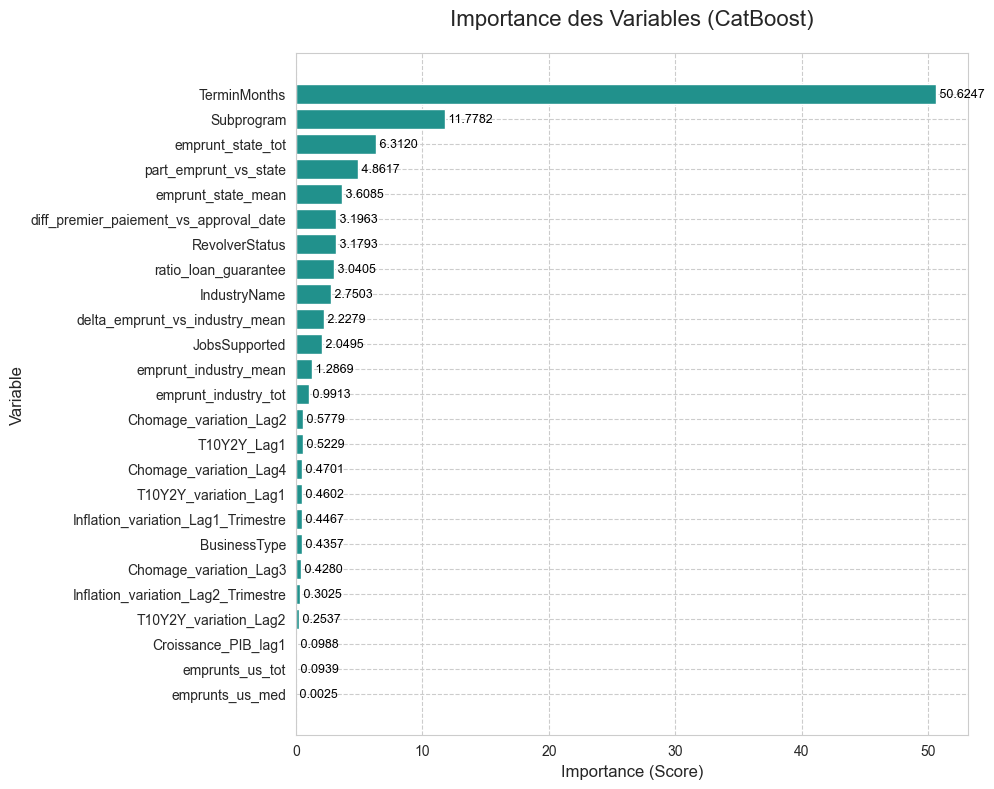

In [325]:
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df_sorted = importance_df_sorted.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.barh(
    importance_df_sorted['Variable'], 
    importance_df_sorted['Importance'],
    color=sns.color_palette("viridis", 1)[0] 
)
plt.title('Importance des Variables (CatBoost)', fontsize=16, pad=20)
plt.xlabel('Importance (Score)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
for index, value in enumerate(importance_df_sorted['Importance']):
    
    plt.text(
        value, 
        index, 
        f' {value:.4f}', 
        va='center', 
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()